# Excerise 2
In this exercise you will explore how hard it is to find the best balance between TPR and FPR. 

We will then turn to applying multi-class classifiers over the well known MNIST digits database, and analyse the results using a confusion matrix.

## Balancing TPR and FPR and interpretability of a classifier results given inbalance between classes
After your yearly checkup, the doctor has bad news and good news. The bad news is that you tested positive for a serious disease, and that the test is 99% accurate (i.e. the probability of testing positive given that you have the disease is 0.99, as is the probability of testing negative given that you don’t have the disease). The good news is that this is a rare disease, striking only 1 in 10,000 people. 

1. What are the TPR and FPR of the chosen classifier in this case? Giving that there is a balance between the two --- is it a good point on the ROC curve? 

2. Why is it good news that the disease is rare? What are the chances that you actually have the disease?

3. Taking into account the previous answers, would you say the designer of the classifier made a good choice in this case?


#### Answer 1
$TPR = \frac{TP}{TP + FN} = 99\%$ (i.e. probability of testing positive for someone who has the disease)

$FPR = \frac{FP}{TN + FP} = 1 - TNR = 100\% - 99\% = 1\%$

$99\% TPR$ for $1\% FPR$ is pretty much an ideal point on the ROC curve because we're maximizing the TPR while minimizing th FPR.

#### Answer 2
Let's first calculate the Probability of having a Positive test result in the general population.
Using the law of total probability we have:

<center>
$\begin{align}
P(Pos) &= P(Pos|Dis)\cdot P(Dis) + P(Pos|Healthy) \cdot P(Healthy) \\
&= 99\% \cdot \dfrac{1}{10000} + 1\% \cdot \dfrac{9999}{10000} \\
&= 1.0098\%
\end{align}$
</center>
    
Using Bayes' Theorem, we have:
<center>
$\begin{align}
P(Dis|Pos) &= \dfrac{P(Pos|Dis)\cdot P(Dis)}{P(Pos)}\\
          &= \dfrac{99\%\cdot 0.01\%}{1.0098\%}\\
          &\approx 0.98\%
\end{align}
$</center>

This is good news because for someone who tested positive, the actual chances of having the disease are only $0.98\%$. As can be seen in  Bayes' equation, the rarity of the disease is causing this number to be very low.

#### Answer 3
As mentioned in Answer 1, it is hard to get a better point on the ROC curve, however because of the rarity of the disease, these rates still mean that there will be an overwhelming proportion of false positives (Answer 2).

Because the disease is serious a classifier should focus on avoiding False Negatives as much as possible. In this case, the designer did a good job, because while there will be a large number of False Positives, 99% of the True Positives will be identified.

## Classifying Digits
In this part we will test digits classification on the MNIST dataset, using Bernoulli Naive Bayes (a generative model) and Multivariate Logistic Regression (a discriminative model). 

The MNIST dataset contains 28x28 grayscale images of handwritten digits between 0 and 9 (10 classes). For mathmatical analysis clarity, and for matching expected API, each image faltten to create a 1D array with 784 elements.

### Loading the MNIST dataset
Load the MNIST data set. The digits dataset is one of datasets scikit-learn comes with that do not require the downloading of any file from some external website. Use 
>```mnist = sklearn.datasets.fetch_mldata('MNIST original')```

to fetch the original data. You may set the `data_home` to where you wish to download your data for caching. Each image is already transformed into a 1D integer array $x\in [0,255]^{784}$, and the corresponding label is an integer $y\in [0,9]$.

Plot a single sample of each digit as the original image, so you get a feeling how the data looks like.

Finally, divide your data into train and test sets, using 1/7 of the data for testing.

---
**Note:** Using `digits = sklearn.datasets.load_digits()` will only fetch a very small sample of the original set, with images resized to 8x8. This preprocessing of the data reduces dimensionality and gives invariance to small distortions - however, we will use the original data in this exercise. Feel free to test the proformance of the algorithms below on the preprocessed data as well.


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import itertools
import random

from sklearn.datasets.mldata import fetch_mldata

test_data = np.load('../MNIST/test_data.npy')
test_labels = np.load('../MNIST/test_labels.npy')
train_data = np.load('../MNIST/train_data.npy')
train_labels = np.load('../MNIST/train_labels.npy')

Showing random picks of numbers from 0 to 9 from the training set


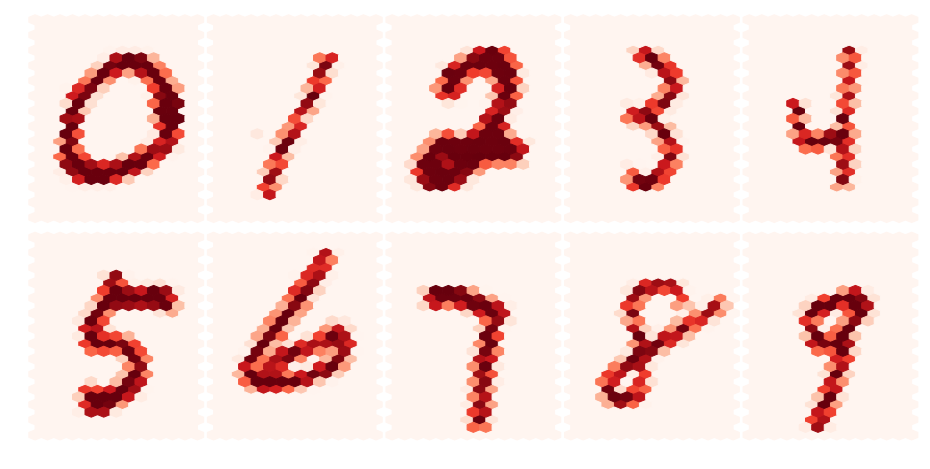

In [44]:
def show_number(img_data, colormap):
    color_map = plt.cm.Spectral_r
    
    coord_x = np.reshape([range(0,28)]*28, (784))
    coord_y = np.reshape([[27-i] * 28 for i in range(0,28)], (784))
    
    plt.axis('off')
    
    image = plt.hexbin(coord_x, coord_y, img_data, gridsize=(13,13), cmap=colormap) 


print('Showing random picks of numbers from 0 to 9 from the training set')

plt.subplots(2,5, figsize=(16, 8))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(0,10):
    plt.subplot(2, 5, i+1)
    index_array = np.where(train_labels==i)
    idx = np.random.choice(len(index_array[0]))
    number_idx = index_array[0][idx]
    show_number(train_data[number_idx],'Reds')

plt.show()

### Bernoulli Naive Bayes
If we know how the digits are generated, then we know how to classify them (simply choose the digit class which will maximize the posterior probability) --- but which model should we use for describing the digits generation?

In this part we will try a very simplified model of digits creation (which is obviously not the same as the "real" model), using a Naive Bayes over an underlying Bernoulli distribution --- that is, we will assume that given a digit class, the pixels of the images are the result of independent coin flips, each with its own "head" probability.

Note that since we assume each pixl is either 0 (black) or 1 (white), we will need to adjust (preprocess) our data accrodingly (see below).

So, the model is stated as follows:
$$
\begin{align}
\text{Domain} && x \in \{0,1\}^{784} \\
\text{Prior} && \pi_j = \Pr(y=j) \\
\text{Likelihood} && P_j(x) = \Pr(x | y=j) \\
\end{align}
$$

Where for each $i\in 0\ldots 784$ it holds that
$$
P_{ji}(x_i) = \Pr(x_i | y=j) =
\begin{cases}
p_{ji} & \text{if } x_i=1 \\
1-p_{ji} & \text{if } x_i=0 \\
\end{cases}
$$


#### Question 1
Write the classification rule based on this Naive Bayes model. 
How would you esitmate each of the parameters of the model based on the trainning data? 


**Bonus:** Think of edge cases which may effect your estimator in an undesired way.

#### Answer 1
The classification rule would be the maximum likelyhood estimator.
Assuming that all features are independent given the class (Naive Bayes) our MLE would be as follows:

<h4><center>
    $\begin{align}
    \hat{y} &= \textrm{arg max}_j \, Pr(j) \prod_{i=1}^{n}Pr(x_i|j) \\
    &= \textrm{arg max}_j \, \dfrac{N_j}{N} \cdot Pr_{j1}(x_1)\cdot Pr_{j2}(x_2) \cdots Pr_{j784}(x_784)
    \end{align}$
</center></h4>
<h4>With
<center>$Pr_{ji}(x_i) = p_{ji}^{x_i} (1-p_{ji})^{1-x_i}$</center></h4>
    


In order to fit the model, for each pixel $i \in 0\cdots784$ we would estimate $\hat P_{ji}(x_i) = \dfrac{N_{ji}}{N_{j}}$ with $N_{ji}$ the number of examples of class $j$ with $x_i = 1$ and $N_j$ the total number of examples of class $j$.


Additionally, we could imagine applying corrections to the above model.
An example would be to pre-process numbers to avoid being adversely affected by non-centered, smaller or bigger numbers than average.
We could for example for a given class estimate the median {top, left, right and bottom}-most pixel and resize the elements of the class to all appear in the same zone.

#### Question 2
Run a Naive Bayes classifier on the training data and apply predictions on the test data. Use the [sklearn.naive_bayes.BernoulliNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) implementation (see the [source code for sklearn.naive_bayes](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/naive_bayes.py) for details).

Remember we need to preprocess the data in this case such that each pixel would become either black (0) or white (1). For this, use the `binarize` parameter of the implementation. Set this value to $0$ (this is the default), which in this case would mean every pixel with non-zero value will be set to 1.

1. Plot the mean image of each class (estimated $\hat{p}_{ji}$) and generate one sample of each class (remeber, you can do this since this is a generative model). You will need to access the `feature_log_prob_` attibute of the trained model.

2. Plot the confusion matrix of your classifier, as claculated on the test data (it is recommended to use [sklearn.metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)). Calculate the total accuracy (fraction of correctly classified images), and summarize the results in your own words.

3. Think of a way you can find the optimal threshold of the binarization part. **There is no need to actually perform this task --- just describe what you would have done.**


#### Answer 2
1. Plot the mean image of each class

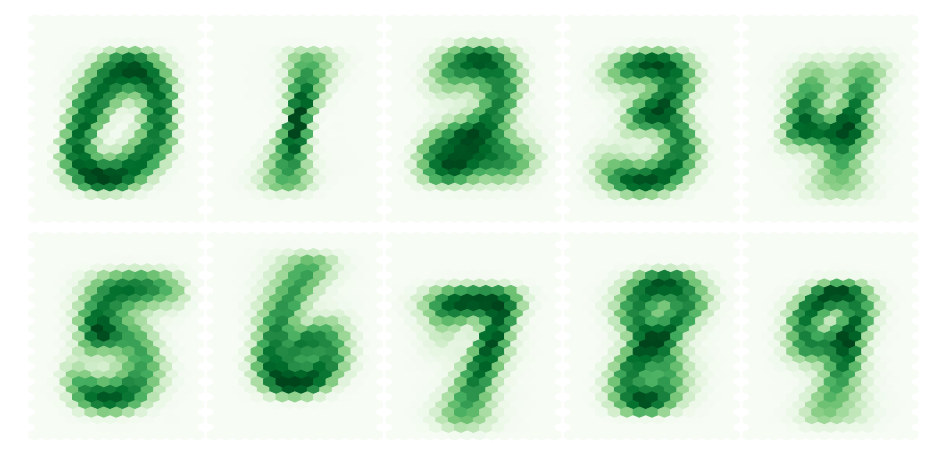

In [45]:
clf = BernoulliNB(binarize=0.0)
clf.fit(train_data, train_labels)
#print(np.exp(clf.feature_log_prob_[1,:]))
plt.subplots(2,5, figsize=(16, 8))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(0,10):
    plt.subplot(2, 5, i+1)
    show_number(np.exp(clf.feature_log_prob_[i,:]),'Greens')
plt.show()

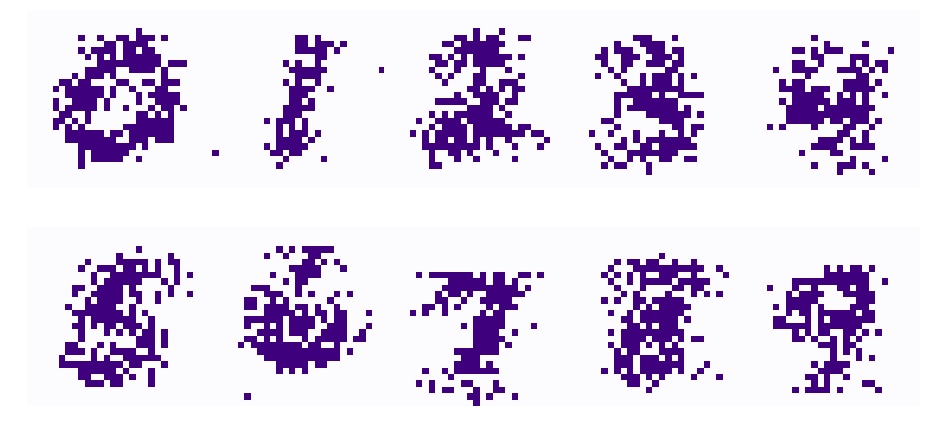

In [46]:
# Lambda function to generate value according to probability 
f = lambda x: random.uniform(0, 1) < x

plt.subplots(2,5, figsize=(16, 8))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(0,10):
    mean_digit = np.exp(clf.feature_log_prob_[i,:])
    new_digit = np.fromiter((f(xi) for xi in mean_digit), mean_digit.dtype, count=len(mean_digit))
    plt.subplot(2, 5, i+1)
    plt.imshow(new_digit.reshape(28,28), cmap='Purples')
    plt.axis('off')

plt.show()

2. The confusion matrix is very useful in this exercise because it allows to understand the limitations of our model.
Namely that the model has a difficult time predicting the number 5 (77% of accurate predictions vs 85% on average).
Also, it allows to understand the confusion between numbers: the model confuses quite often the digit 5 with the 3 or the 9 with the 4.

In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Accurately predicted 84.70% of results


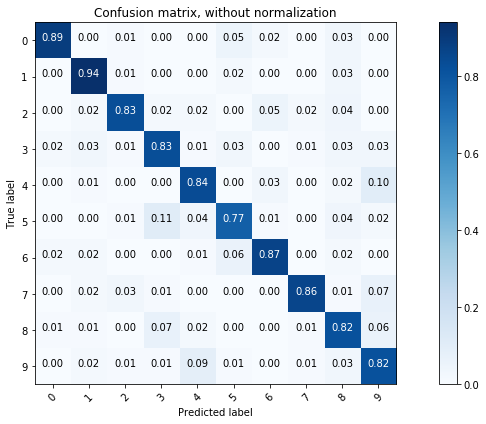

In [52]:
y_pred = clf.predict(test_data)
cnf_matrix = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(12, 6))
plot_confusion_matrix(cnf_matrix, range(0,10), True, title='Confusion matrix, without normalization')

score = clf.score(test_data, test_labels)
print("Accurately predicted %.2f%% of results" % (100*score))

3. We could optimize the threshold using gradient descent in order to identify the optimal value.

### Multivariate Logistic Regression
We will now look at a discriminative model for this problem, specifically, the Multivariate Logistic Regression model. Again, we will use a prepared implementation of the model, so you won't need to implement it.

In this part we will keep the pixel values in grayscale, and assume the probability of each image being classified as one of the 10 digit classes, matches some multivariate logistic function.

#### Question 3
Run a Multivariate Logitic Regression classifier on the training data and apply predictions on the test data. Use the [sklearn.linear_model.LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) implementation, and set the `solver` to be `'lbfgs'`.

1. As we did for the Naive Bayes classifier above, plot the confusion matrix of your classifier, as claculated on the test data, and calculate the total accuracy. Summarize the results in your own words.

2. Show some test images which were missclassified (classified incorrectly). Choose one such sample, and output the probability estimates for all classes (use the `predict_proba` function). Describe the results.

Note that here we cannot "generate" examples from the model, nor plot the "mean image".

#### Answer 3
1. The Multivariate Logistic Regression classifier returned an accuracy of 86% which is a maginal improvement from the Naive Bayes classification.
The confusion matrix however, indicates that the model is struggling on different digits.
For example, the Logistic Regression pretty accurately distinguishes between 9 and 4 (where Naive Bayes had more difficulty) but it is distinguishing with much less accuracy between digits 8 and 4.
A 'best of both worlds' approach, consisting in using one model for some predictions, and the other model otherwise, would allow to significantly improve the prediction accuracy.


2. The logistic regression model seems to sometimes struggle on values that are obvious to the human eye, sometimes giving a 0% probability to the true class! This is a weakness, but it could also be used to our advantage because this means that this model derives its accuracy from non-trivial features of the digit shape. As suggested in answer 1, used in conjonction with another model this could prove a powerful addition that will allow to classify the values that are difficult to classify to other models.

Accurately predicted 86.00% of results


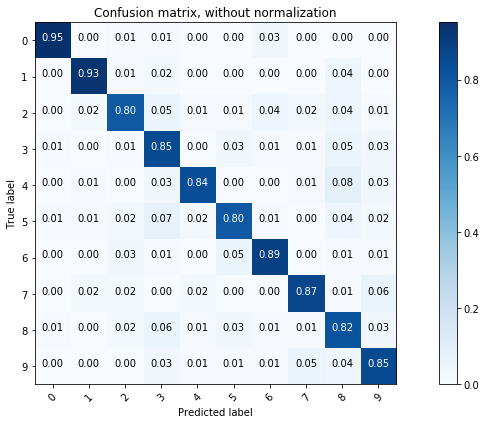

In [57]:
clf = LogisticRegression(solver='lbfgs')
clf.fit(train_data, train_labels)

score = clf.score(test_data, test_labels)
print("Accurately predicted %.2f%% of results" % (100*score))

y_pred = clf.predict(test_data)
cnf_matrix = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(12, 6))
plot_confusion_matrix(cnf_matrix, range(0,10), True, title='Confusion matrix, without normalization')

True Label = 4, Predicted value = 3 
Probability estimates - [0:0.0%, 1:0.0%, 2:0.0%, 3:79.2%, 4:0.0%, 5:0.6%, 6:0.0%, 7:0.0%, 8:0.0%, 9:20.1%]


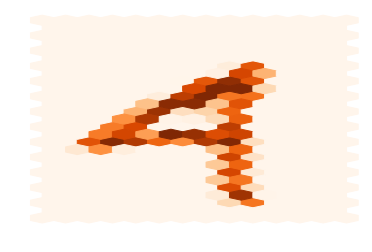

True Label = 8, Predicted value = 3 
Probability estimates - [0:0.0%, 1:0.0%, 2:0.0%, 3:58.8%, 4:0.0%, 5:0.0%, 6:0.0%, 7:0.0%, 8:41.1%, 9:0.0%]


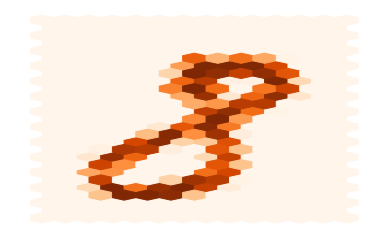

True Label = 6, Predicted value = 5 
Probability estimates - [0:0.0%, 1:0.0%, 2:0.0%, 3:43.7%, 4:0.0%, 5:45.9%, 6:0.0%, 7:0.0%, 8:10.4%, 9:0.0%]


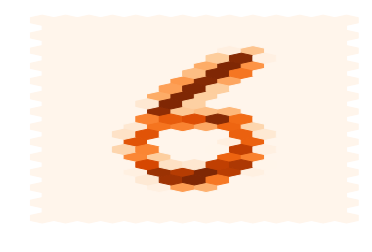

True Label = 5, Predicted value = 4 
Probability estimates - [0:0.0%, 1:0.0%, 2:0.0%, 3:0.0%, 4:52.0%, 5:0.0%, 6:0.0%, 7:0.0%, 8:48.0%, 9:0.0%]


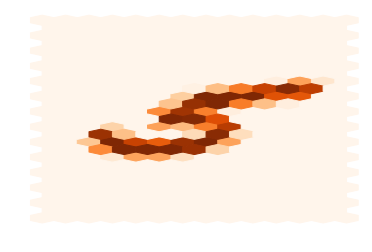

In [58]:
wrong_predictions = (test_labels != y_pred)
test_data_wrong = test_data[wrong_predictions]
test_label_wrong = test_labels[wrong_predictions]
y_pred_wrong = y_pred[wrong_predictions]

for i in range(0, 4):
    # Pick prediction errors randomly
    idx = np.random.choice(len(test_data_wrong))
    print("True Label = %d, Predicted value = %d " % (test_label_wrong[idx], y_pred_wrong[idx]))
    predicted_probas = clf.predict_proba([test_data_wrong[idx]])
    print('Probability estimates - [%s]' % ', '.join(['%d:%.1f%%' % (i, 100*v) for i, v in enumerate(predicted_probas[0])]))
    show_number(test_data_wrong[idx],'Oranges')
    plt.show()